# Copyright
<pre>
Jelen forráskód a Budapesti Műszaki és Gazdaságtudományi Egyetemen tartott
"Deep Learning a gyakorlatban Python és LUA alapon" tantárgy segédanyagaként készült.

A tantárgy honlapja: http://smartlab.tmit.bme.hu/oktatas-deep-learning
Deep Learning kutatás: http://smartlab.tmit.bme.hu/deep-learning

A forráskódot GPLv3 licensz védi. Újrafelhasználás esetén lehetőség szerint kérjük
az alábbi szerzőt értesíteni.

2021 (c) Csapó Tamás Gábor (csapot kukac tmit pont bme pont hu),
Gyires-Tóth Bálint, Zainkó Csaba


Original GAN example from:

Links:
[Keras-GAN] https://github.com/eriklindernoren/Keras-GAN/blob/master/gan/gan.py
</pre>


In [ ]:
# original example from https://github.com/eriklindernoren/Keras-GAN/blob/master/gan/gan.py

In [1]:
# itt most lehet újra tf2
%tensorflow_version 2.x

In [3]:
from tensorflow import keras

In [5]:
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential, Model

import matplotlib.pyplot as plt
import numpy as np

In [6]:
class GAN_image():

  # diszkriminátor hálózat: képről bináris döntés,
  # hogy valódi vagy hamis
  def build_discriminator(self):
    model = Sequential()
    
    model.add(Flatten(input_shape = self.img_shape))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2)) # LeakyReLU, a sima ReLU helyett
    model.add(Dense(256))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(1, activation = 'sigmoid'))
    
    model.summary()
    
    img = Input(shape=self.img_shape)
    
    validity = model(img)
    
    return Model(img, validity)
  
  # generátor hálózat: zajból kép generálás
  def build_generator(self):
    model = Sequential()
    
    model.add(Dense(256, input_dim = self.latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8)) # BatchNorm: előadáson
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(1024))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(np.prod(self.img_shape), activation='tanh'))
    model.add(Reshape(self.img_shape))
    
    model.summary()
    
    noise = Input(shape=(self.latent_dim,))
    img = model(noise)
    
    return Model(noise, img)
  
  
  def __init__(self):
    self.img_rows = 28
    self.img_cols = 28
    self.channels = 1
    self.img_shape = (self.img_rows, self.img_cols, self.channels)
    
    # látens dimenzió: belső reprezentáció mérete
    self.latent_dim = 100
    
    optimizer = keras.optimizers.Adam(0.0002, 0.5)
    
    # diszkriminátor build és compile
    self.discriminator = self.build_discriminator()
    self.discriminator.compile(loss = 'binary_crossentropy',
                              optimizer=optimizer,
                              metrics=['accuracy'])
    
    # generátor build
    self.generator = self.build_generator()
    
    # generátor: zaj bemenetből képet készít
    z = Input(shape=(self.latent_dim,))
    img = self.generator(z)
    
    # együttes modell - itt csak a generátort tanítjuk
    # (a diszkriminátorra már volt build fent,
    # így csak a közös hálózatban lévő diszkriminátor nem lesz tanítható)
    self.discriminator.trainable = False
    
    # diszkriminátor: generált képekről eldönti, hogy valódiak-e
    validity = self.discriminator(img)
    
    # együttes modell
    # cél: a generátor megtanulja, hogyan csaphatja be a diszkriminátort
    self.combined = Model(z, validity)
    self.combined.compile(loss = 'binary_crossentropy',
                         optimizer=optimizer)

  


In [7]:
# tanítás paraméterek
steps = 30000
batch_size = 128
sample_interval = 50

In [10]:
# az első summary a diszkriminátor hálózat,
#  (kép -> bináris döntés)
# a második summary a generátor hálózatra vonatkozik
#  (mintavételezett zaj -> kép)

gan = GAN_image()


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 784)               0         
                                                                 
 dense_14 (Dense)            (None, 512)               401920    
                                                                 
 leaky_re_lu_10 (LeakyReLU)  (None, 512)               0         
                                                                 
 dense_15 (Dense)            (None, 256)               131328    
                                                                 
 leaky_re_lu_11 (LeakyReLU)  (None, 256)               0         
                                                                 
 dense_16 (Dense)            (None, 1)                 257       
                                                                 
Total params: 533,505
Trainable params: 533,505
Non-tr

In [11]:
# adatok betöltése
from keras.datasets import mnist
(x_train, _), (_, _) = mnist.load_data()

# skálázás -1 és 1 közé
x_train = x_train / 127.5 - 1
x_train = np.expand_dims(x_train, axis = 3) # legyen channel dim is

# diszkriminátor kimenetek
valid = np.ones((batch_size, 1)) # D(x)    = 1
fake = np.zeros((batch_size, 1)) # D(G(z)) = 0


11501568/11490434 [==============================] - 0s 0us/step


In [12]:
# generált képek kirajzolása

from IPython import display

def plot_images(gan, step):
  r, c = 2,5
  noise = np.random.normal(0, 1, (r * c, gan.latent_dim))
  gen_imgs = gan.generator.predict(noise)
  
  # átskálázás: 0-1 (from -1 -- 1)
  gen_imgs = 0.5 * gen_imgs + 0.5
  
  plt.title('step ' + str(step))
  fig, ax = plt.subplots(r, c)
  cnt = 0
  for i in range(r):
    for j in range(c):
      ax[i,j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
      ax[i,j].axis('off')
      cnt += 1
  
  display.display(plt.gcf())
      

0 loss_D 0.7735198736190796 loss_G 0.6382176876068115


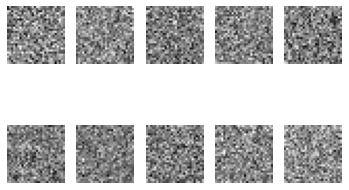

100 loss_D 0.6227789670228958 loss_G 2.687857151031494


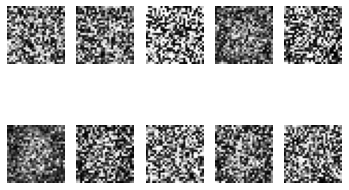

200 loss_D 0.736344188451767 loss_G 0.921852171421051


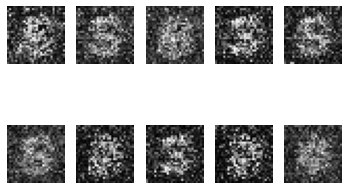

300 loss_D 0.6478160321712494 loss_G 0.6395180225372314


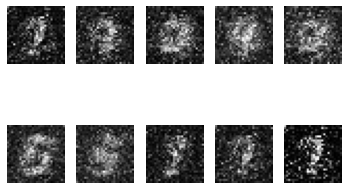

400 loss_D 0.6433945894241333 loss_G 0.6788202524185181


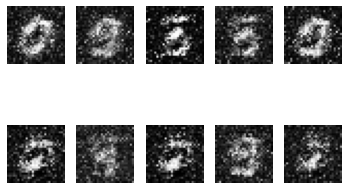

500 loss_D 0.6411036252975464 loss_G 0.712688684463501


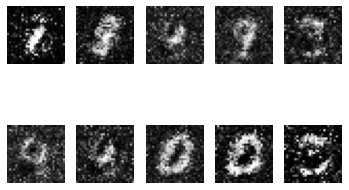

600 loss_D 0.6550131738185883 loss_G 0.758232831954956


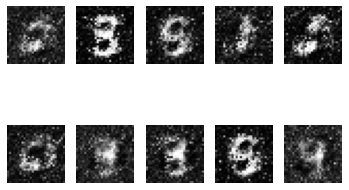

700 loss_D 0.6178760826587677 loss_G 0.8666795492172241


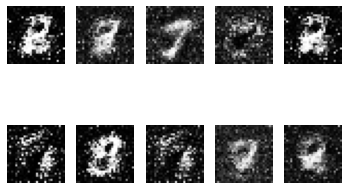

800 loss_D 0.6060328483581543 loss_G 0.8760987520217896


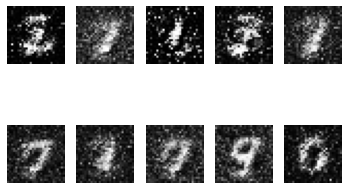

900 loss_D 0.5894600749015808 loss_G 0.9166405200958252


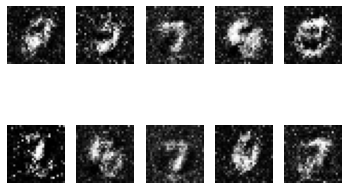

1000 loss_D 0.5790557861328125 loss_G 0.99968022108078


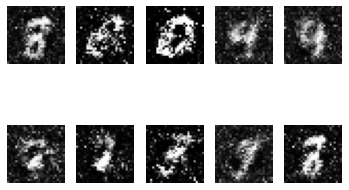

1100 loss_D 0.5428362041711807 loss_G 0.9867829084396362


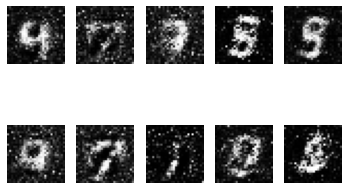

1200 loss_D 0.5810468196868896 loss_G 1.0542938709259033


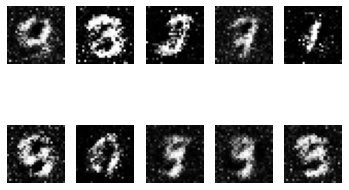

1300 loss_D 0.5631777942180634 loss_G 1.0273009538650513


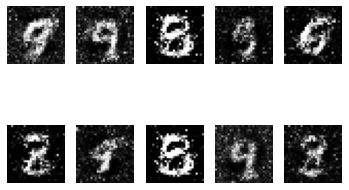

1400 loss_D 0.5690359771251678 loss_G 1.0635641813278198


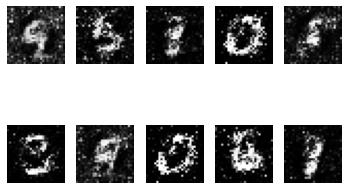

1500 loss_D 0.5203355401754379 loss_G 1.084477424621582


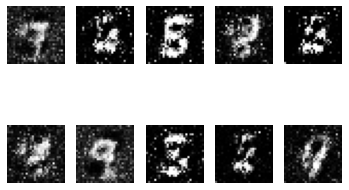

1600 loss_D 0.5794566571712494 loss_G 1.0700865983963013


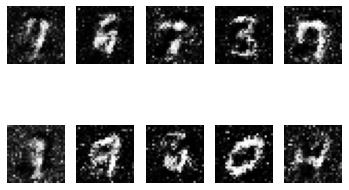

1700 loss_D 0.5610981583595276 loss_G 1.036285638809204


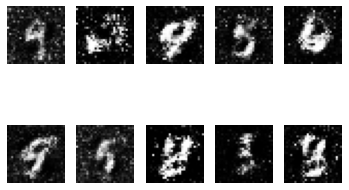

1800 loss_D 0.5543481111526489 loss_G 1.0491992235183716


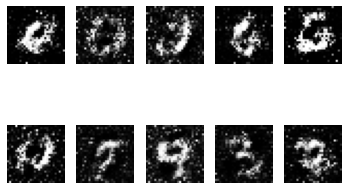

1900 loss_D 0.583671897649765 loss_G 0.9802532196044922


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


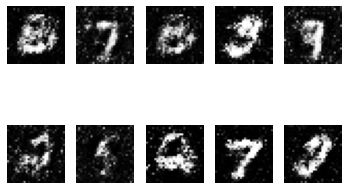

2000 loss_D 0.5664529502391815 loss_G 1.0511786937713623


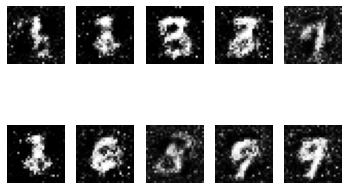

2100 loss_D 0.5755016207695007 loss_G 1.0512661933898926


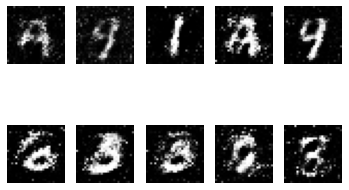

2200 loss_D 0.5839180648326874 loss_G 1.0191667079925537


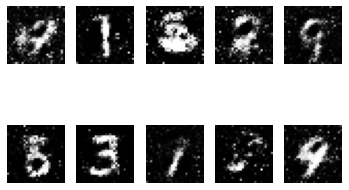

2300 loss_D 0.5893825888633728 loss_G 0.9883674383163452


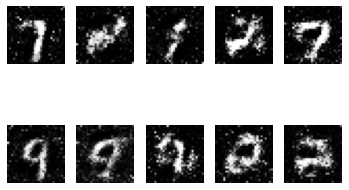

2400 loss_D 0.5838989019393921 loss_G 0.983799934387207


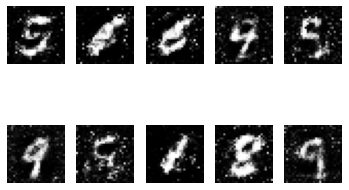

2500 loss_D 0.5757842361927032 loss_G 1.019452691078186


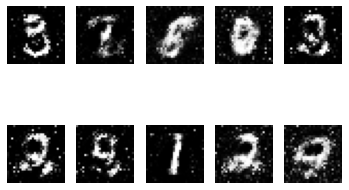

2600 loss_D 0.5802564918994904 loss_G 0.9960651397705078


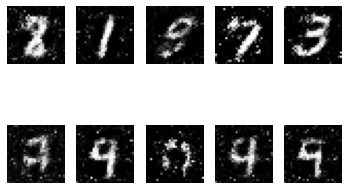

2700 loss_D 0.5898374319076538 loss_G 0.9725803136825562


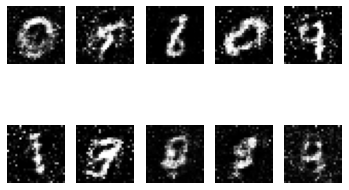

2800 loss_D 0.6150359809398651 loss_G 0.9654996395111084


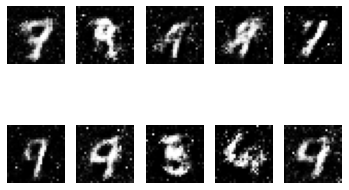

2900 loss_D 0.61921826004982 loss_G 0.9436601400375366


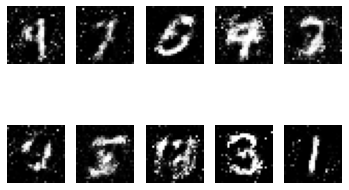

3000 loss_D 0.6412051022052765 loss_G 0.9211956262588501


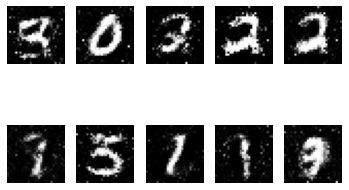

3100 loss_D 0.6237950921058655 loss_G 0.913480281829834


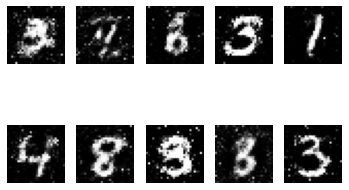

3200 loss_D 0.6210922002792358 loss_G 0.8922057747840881


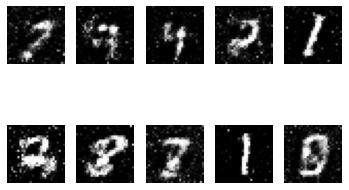

3300 loss_D 0.6263101100921631 loss_G 0.9503273367881775


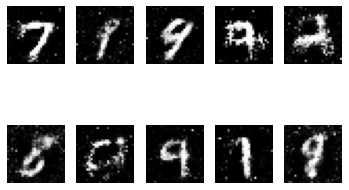

3400 loss_D 0.6512498259544373 loss_G 0.9012666940689087


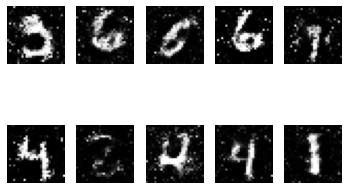

3500 loss_D 0.606673538684845 loss_G 0.9339366555213928


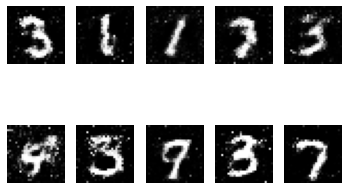

3600 loss_D 0.6330746412277222 loss_G 0.8844375610351562


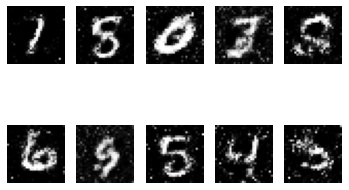

3700 loss_D 0.6287137269973755 loss_G 0.898073136806488


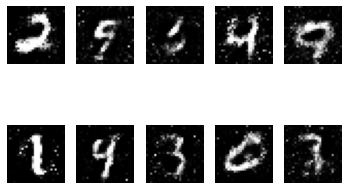

3800 loss_D 0.6579329371452332 loss_G 0.8823664784431458


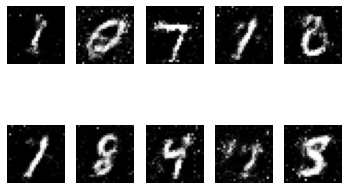

3900 loss_D 0.6885455846786499 loss_G 0.8605225086212158


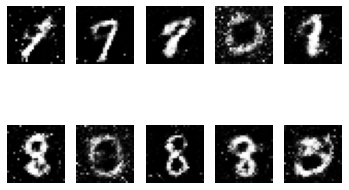

4000 loss_D 0.6605935096740723 loss_G 0.887774646282196


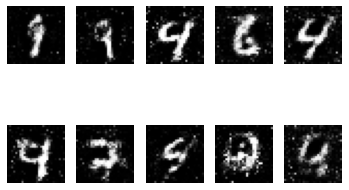

4100 loss_D 0.6523897349834442 loss_G 0.8875226974487305


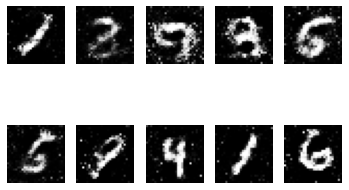

4200 loss_D 0.6597815752029419 loss_G 0.8962715864181519


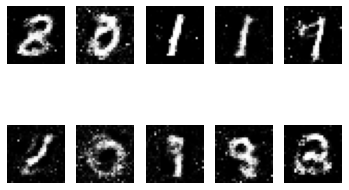

4300 loss_D 0.6185092329978943 loss_G 0.887527585029602


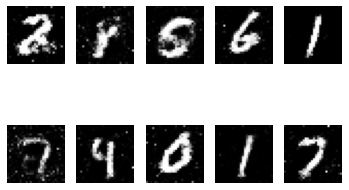

4400 loss_D 0.6389599740505219 loss_G 0.9054347276687622


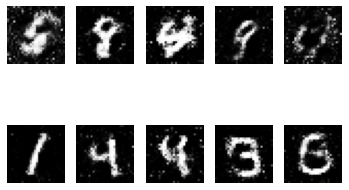

4500 loss_D 0.668258935213089 loss_G 0.8591848015785217


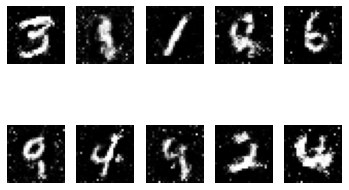

4600 loss_D 0.6390129327774048 loss_G 0.8790343999862671


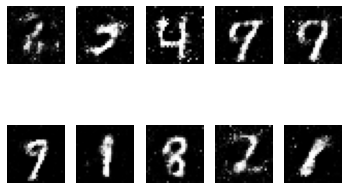

4700 loss_D 0.6248927116394043 loss_G 0.8980772495269775


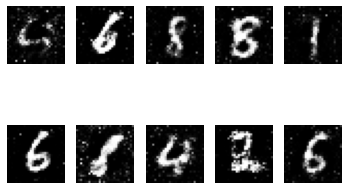

4800 loss_D 0.6480271816253662 loss_G 0.8904514312744141


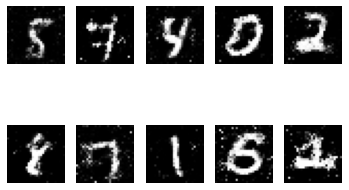

4900 loss_D 0.6484135389328003 loss_G 0.8955662846565247


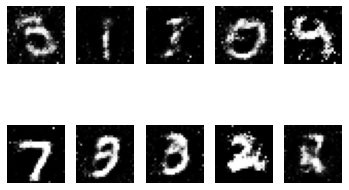

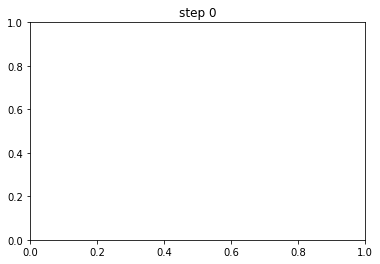

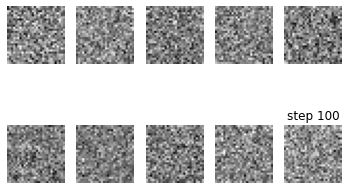

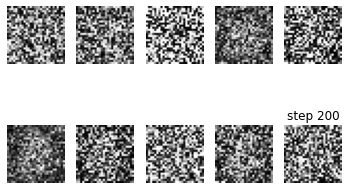

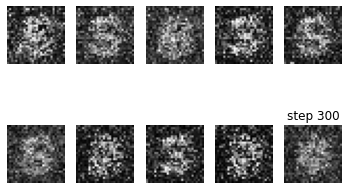

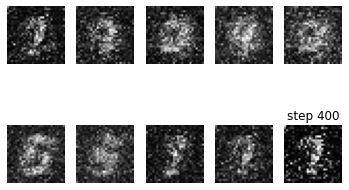

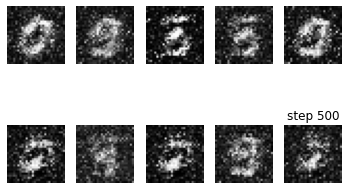

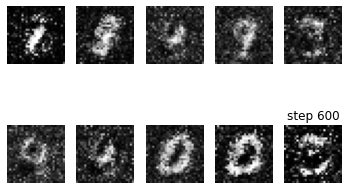

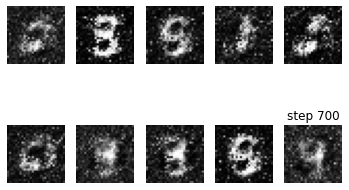

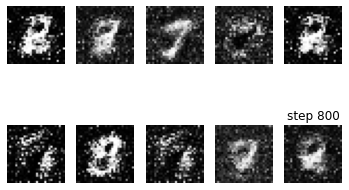

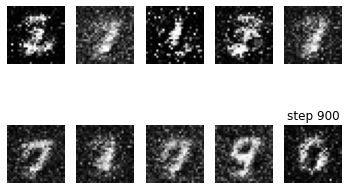

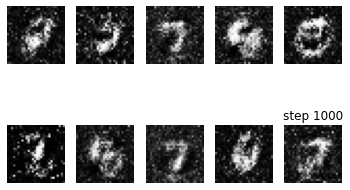

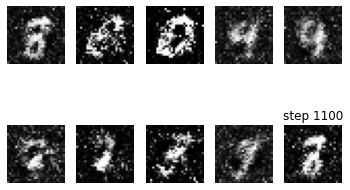

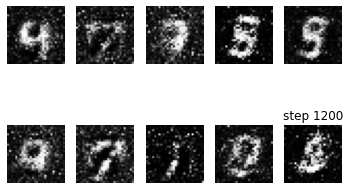

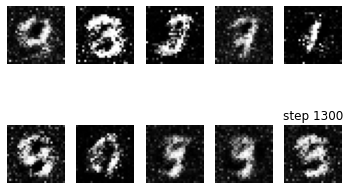

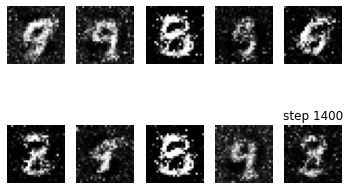

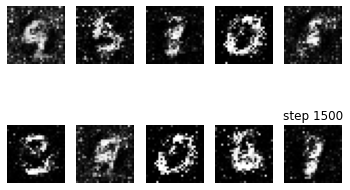

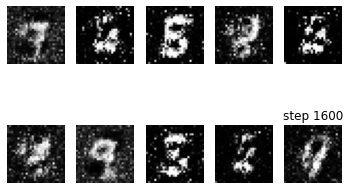

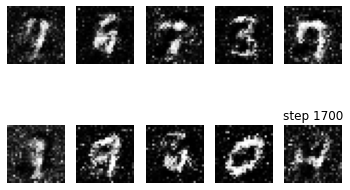

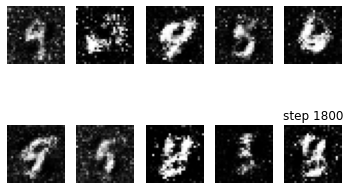

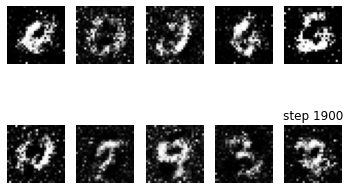

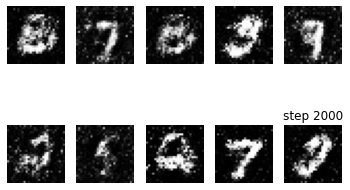

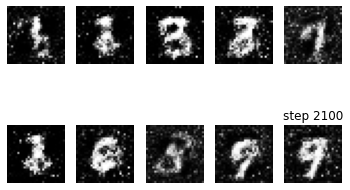

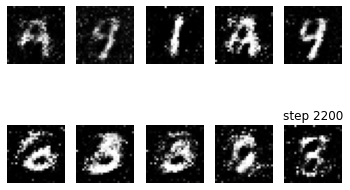

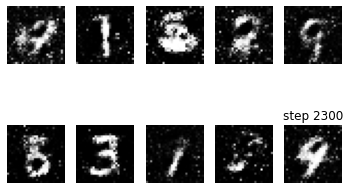

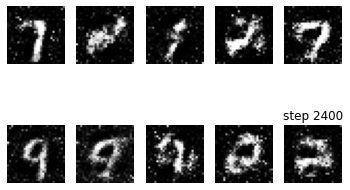

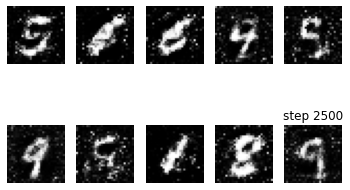

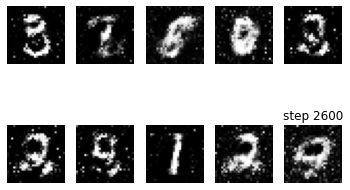

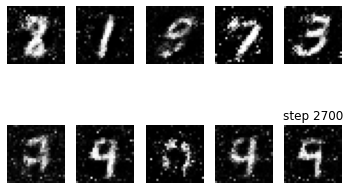

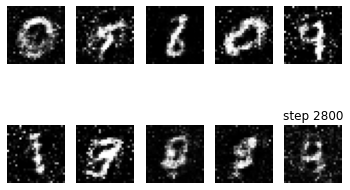

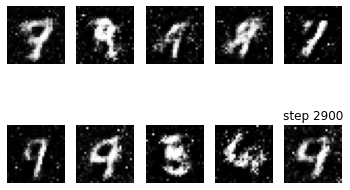

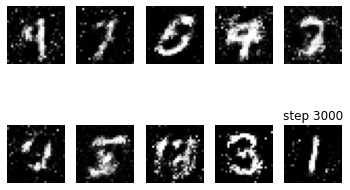

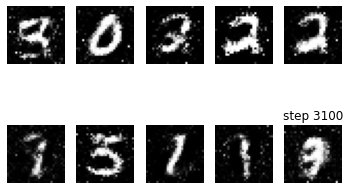

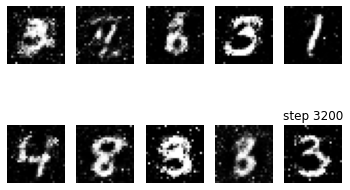

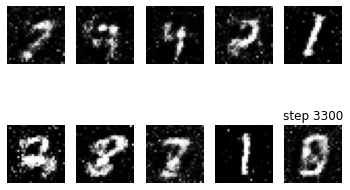

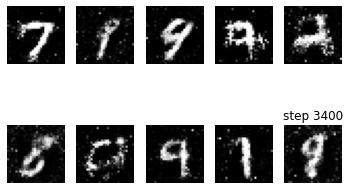

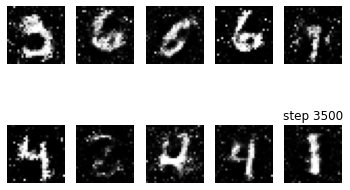

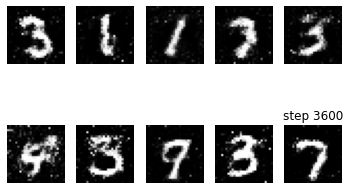

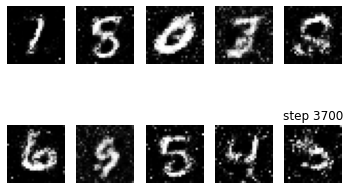

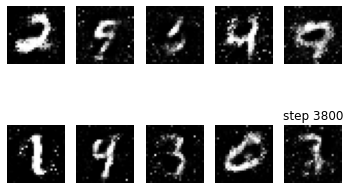

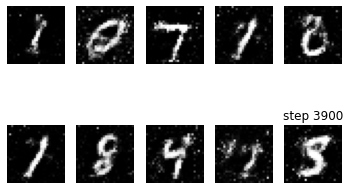

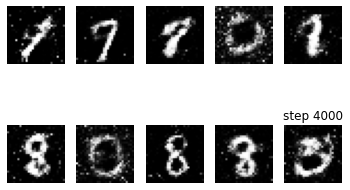

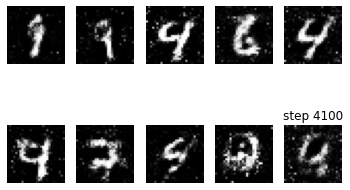

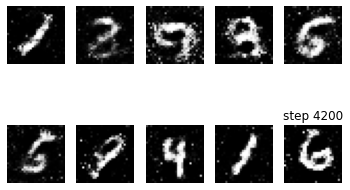

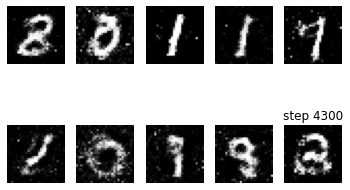

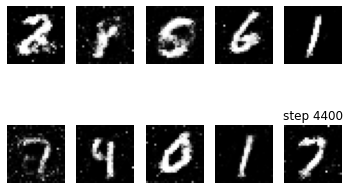

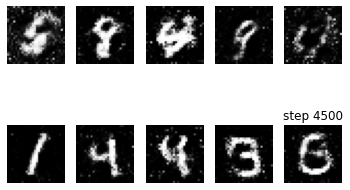

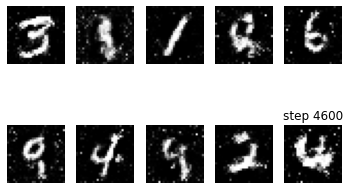

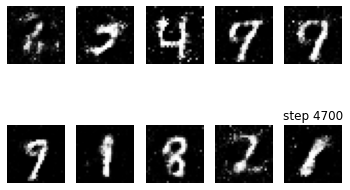

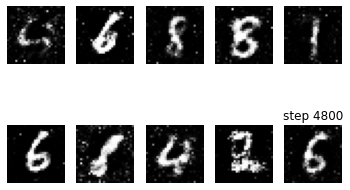

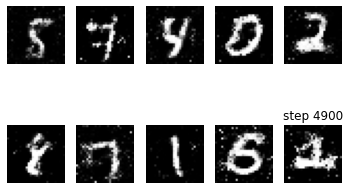

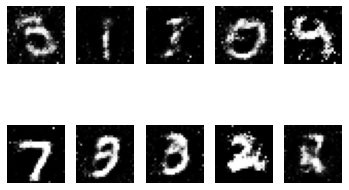

In [13]:
# G és D tanítása, kirajzolással

for step in range(5000):
    
  # képekből véletlen batch-nyi kiválasztása
  idx = np.random.randint(0, x_train.shape[0], batch_size)
  imgs = x_train[idx]
  
  
  # egy batch-nyi kép generálás
  noise = np.random.normal(0, 1, (batch_size, gan.latent_dim))
  gen_imgs = gan.generator.predict(noise)
  
  # diszkriminátor tanítása
  d_loss_real = gan.discriminator.train_on_batch(imgs, valid)
  d_loss_fake = gan.discriminator.train_on_batch(gen_imgs, fake)
  d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
  
  
  # generátor tanítása
  g_loss = gan.combined.train_on_batch(noise, valid)
  
  # log
  if step % 100 == 0:
    print(step, 'loss_D', d_loss[0], 'loss_G', g_loss)
    
  # generált képek kirajzolása
  if step % 100 == 0:
    plot_images(gan, step)
    

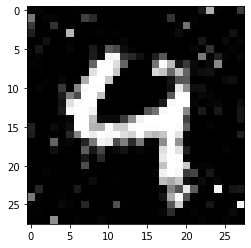

In [14]:
# 1 db digit generálása (többször ismételhető)
# esetleg össze lehet hasonlítani az előző VAE generált példával
noise = np.random.normal(0, 1, (1, gan.latent_dim))
gen_img = gan.generator.predict(noise)
plt.imshow(gen_img.squeeze(), cmap='gray')

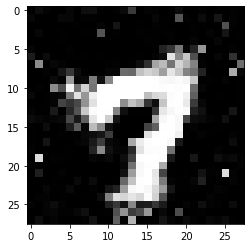

In [17]:
# 1 db digit generálása (többször ismételhető)
# esetleg össze lehet hasonlítani az előző VAE generált példával
noise = np.random.normal(0, 1, (1, gan.latent_dim))
gen_img = gan.generator.predict(noise)
plt.imshow(gen_img.squeeze(), cmap='gray')

In [ ]:
# itt a vége.
# az alap GAN tehát ennyit tud: véletlen zaj alapján digiteket tud generálni,
# de azt nem tudjuk befolyásolni, hogy milyen digit legyen a képen